In [1]:
!pip install pytorch-metric-learning --quiet
!pip install faiss-cpu --quiet

In [2]:
# --- PyTorch Metric Learning Imports ---
from pytorch_metric_learning import losses, miners, distances, reducers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning import testers

import torch
import torch.nn as nn
import faiss
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, BatchSampler
import torch.nn.functional as F

import numpy as np
import os
import random
from tqdm import tqdm

# Data settings

In [3]:
# --- Data Setting ---
import zipfile, os

zip_path = "/content/Dataset_v3.2.zip"
DS_DIR = "Dataset_v3.2"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(DS_DIR)

print("✅ Dataset extracted to:", DS_DIR)

✅ Dataset extracted to: Dataset_v3.2


### Data splitting

In [4]:
import shutil
def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    # Set seed for reproducibility
    random.seed(42)

    # Create output directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    for brand in os.listdir(source_dir):
        brand_path = os.path.join(source_dir, brand)
        if not os.path.isdir(brand_path):
            continue

        images = [
            f for f in os.listdir(brand_path)
            if os.path.isfile(os.path.join(brand_path, f))
        ]
        random.shuffle(images)

        n = len(images)
        train_end = int(train_ratio * n)
        val_end = train_end + int(val_ratio * n)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split_name, split_images in splits.items():
            dest_dir = os.path.join(output_dir, split_name, brand)
            os.makedirs(dest_dir, exist_ok=True)
            for img_name in split_images:
                src_path = os.path.join(brand_path, img_name)
                dst_path = os.path.join(dest_dir, img_name)
                shutil.copy2(src_path, dst_path)

        # print(f"{brand}: train={train_end}, val={val_end-train_end}, test={n-val_end}")
    print("✅ Dataset split into train, val, and test sets")

In [5]:
# Split the data - train, test, val
source_directory = "Dataset_v3.2/Dataset_v3.2"
output_directory = "Dataset3.2"
split_dataset(source_directory, output_directory)

✅ Dataset split into train, val, and test sets


# Model settings

In [3]:

# --- functions for seed setting ---
def set_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Data Sampler (BalancedBatchSampler/P-K Sampler) ---
class BalancedBatchSampler(BatchSampler):
    """
    Samples P classes and K instances per class, forming a batch of P*K samples.
    """
    def __init__(self, labels, num_instances_per_class, batch_size):
        self.labels = np.array(labels)
        self.num_instances_per_class = num_instances_per_class
        self.batch_size = batch_size
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(self.labels == label)[0] for label in self.labels_set}
        for label in self.labels_set:
            np.random.shuffle(self.label_to_indices[label])
        self.used_label_indices = {label: 0 for label in self.labels_set}

        self.num_classes_per_batch = self.batch_size // self.num_instances_per_class
        if self.num_classes_per_batch * self.num_instances_per_class != self.batch_size:
            raise ValueError(f"Batch size ({batch_size}) must be a multiple of num_instances_per_class ({num_instances_per_class})")

        self.length = len(self.labels) // self.batch_size

        self.batches = []
        for _ in range(self.length):
            batch = []
            classes_in_batch = np.random.choice(self.labels_set, self.num_classes_per_batch, replace=False)

            for class_label in classes_in_batch:
                start_idx = self.used_label_indices[class_label]
                end_idx = start_idx + self.num_instances_per_class

                if end_idx > len(self.label_to_indices[class_label]):
                    np.random.shuffle(self.label_to_indices[class_label])
                    self.used_label_indices[class_label] = 0
                    start_idx = 0
                    end_idx = self.num_instances_per_class

                batch.extend(self.label_to_indices[class_label][start_idx:end_idx])
                self.used_label_indices[class_label] = end_idx
            self.batches.append(batch)

    def __iter__(self):
        np.random.shuffle(self.batches)
        for batch in self.batches:
            yield batch

    def __len__(self):
        return self.length

# --- Model Definition (ResNet50 + Embedding Head) ---
from torchvision.models import resnet50, resnet101
import torch.nn.init as init

def mixup_data(p, n, lam):
    mixed_x = lam * p + (1 - lam) * n
    return mixed_x

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_size, pretrained=True, freeze_bn=True, is_norm=True):
        super(EmbeddingNet, self).__init__()
        self.model = resnet50(pretrained=pretrained)
        self.is_norm = is_norm
        self.embedding_size = embedding_size
        self.num_ftrs = self.model.fc.in_features

        # Remove default FC head and add pooling + embedding
        self.model.fc = nn.Identity()
        self.model.gap = nn.AdaptiveAvgPool2d(1)
        self.model.gmp = nn.AdaptiveMaxPool2d(1)
        # self.dropout = nn.Dropout(p=0.5)
        self.model.embedding = nn.Linear(self.num_ftrs, self.embedding_size)

        self._initialize_weights()

        if freeze_bn:
            for m in self.model.modules():
                if isinstance(m, nn.BatchNorm2d):
                    m.eval()
                    for param in m.parameters():
                        param.requires_grad = False

    def _initialize_weights(self):
        init.kaiming_normal_(self.model.embedding.weight, mode='fan_out')
        init.constant_(self.model.embedding.bias, 0)

    def l2_norm(self, input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-12)
        norm = torch.sqrt(normp)
        output = torch.div(input, norm.view(-1, 1).expand_as(input))
        return output.view(input_size)

    def forward(self, x): # Simplified forward
        # Pass through stem and layers
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        # Global pooling
        avg_x = self.model.gap(x)
        max_x = self.model.gmp(x)
        x = avg_x + max_x

        x = x.view(x.size(0), -1)
        # x = self.dropout(x)
        x = self.model.embedding(x)

        if self.is_norm:
            x = self.l2_norm(x)

        return x



In [4]:
from torch.utils.data import Dataset, DataLoader, Sampler, Subset
from PIL import Image

class BeerCapDataset(Dataset):
    def __init__(self, dataset_dir, transform):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        self.transform = transform

        brands = sorted(os.listdir(dataset_dir))
        for idx, brand in enumerate(brands):
            self.class_to_idx[brand] = idx
            self.idx_to_class[idx] = brand # Store inverse mapping
            brand_dir = os.path.join(dataset_dir, brand)
            for img_file in os.listdir(brand_dir):
                self.image_paths.append(os.path.join(brand_dir, img_file))
                self.labels.append(idx)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img), self.labels[idx]

    def __len__(self):
        return len(self.image_paths)


# Util functions

In [5]:
# --- Function to Collect Embeddings ---
def collect_embeddings(dataloader, model, device):
    all_embeddings = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Collecting Embeddings", leave=False):
            data = data.to(device)
            embeddings = model(data)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())
    return torch.cat(all_embeddings), torch.cat(all_labels)

# --- Custom Recall@K Calculation Function ---
def compute_recall_at_k(query_embeddings, query_labels, k_values=[1, 2, 4, 8]):
    """
    Computes Recall@K for given query embeddings and labels.
    Assumes query_embeddings are L2-normalized.
    """
    num_queries = query_embeddings.size(0)

    # Calculate cosine similarity between all embeddings
    # (query_embeddings @ query_embeddings.T) results in a similarity matrix
    # Shape: (num_queries, num_queries)
    similarity_matrix = torch.matmul(query_embeddings, query_embeddings.T,)

    # Sort similarities in descending order to get top neighbors
    # `indices` will contain the original indices of the sorted similarities
    sorted_indices = torch.argsort(similarity_matrix, dim=1, descending=True)

    # Initialize recalls for each K
    recalls = {k: 0 for k in k_values}
    max_k = max(k_values)

    for i in tqdm(range(num_queries), desc="Calculating Recall@K", leave=False):
        query_label = query_labels[i]

        # Get the indices of the top-max_k most similar embeddings for the current query
        # We exclude the query itself (index 0 in sorted_indices)
        top_k_indices = sorted_indices[i, 1 : max_k + 1] # Start from index 1 to exclude self

        # Get the labels of these top-K neighbors
        top_k_labels = query_labels[top_k_indices]

        # Check if any of the top-K labels match the query label
        # `torch.eq` performs element-wise equality check
        # `any()` checks if any of the matches are True
        is_correct_match = torch.eq(top_k_labels, query_label)

        for k in k_values:
            # Check if a correct match exists within the top 'k' results
            if torch.any(is_correct_match[:k]):
                recalls[k] += 1

    # Calculate average recall for each K
    for k in k_values:
        recalls[k] = recalls[k] / num_queries

    return recalls

# Training

In [43]:
# --- Setup ---

seed = 42
data_root = 'Dataset3.2'
embedding_size = 512

batch_size = 64
images_per_class = 8

num_epochs = 31
lr = 1e-4
weight_decay = 1e-3
lr_decay_step = 15
lr_decay_gamma = 0.1
num_workers = 4 # Set to 0 for stability in Colab
save_model_path = 'checkpoints/best_beer_caps_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
set_seeds(seed)

# --- Test Transformers ---
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# --------------------------

# --- Train transformer ---> Choose one
# train_transform_geometric_emphasis = transforms.Compose([
#     # 1. Random Resized Crop: Essential for varying object scale and context
#     # Allowing for slightly more aggressive scaling and aspect ratio changes
#     transforms.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.6, 1.4)),

#     # 2. Random Horizontal Flip: Standard and effective for symmetry
#     transforms.RandomHorizontalFlip(),

#     # 3. Random Rotation: Significant rotations to handle all cap orientations
#     transforms.RandomRotation(degrees=30), # Increased from 30 to 45 degrees

#     # 4. Random Affine: Crucial for translation, scaling, and especially SHEAR
#     # Shear is very important for text on curved surfaces or oblique views.
#     transforms.RandomAffine(
#         degrees=0, # Rotation handled by RandomRotation
#         translate=(0.15, 0.15), # Increased translation range (more shifting)
#         scale=(0.8, 1.2), # Increased scaling range (more zooming in/out)
#         shear=20, # Increased shear significantly (more skewing, very impactful for text)
#         # resample=transforms.InterpolationMode.BILINEAR # Good quality interpolation
#     ),

#     # 5. Random Perspective: Simulates 3D viewpoint changes (highly geometric)
#     # Increased distortion scale to make it more pronounced
#     transforms.RandomPerspective(
#         distortion_scale=0.4, # Increased from 0.3
#         p=0.6, # Increased probability of applying (from 0.5)
#         interpolation=transforms.InterpolationMode.BILINEAR # Good quality interpolation
#     ),

#     # --- Other important augmentations (balanced intensity) ---

#     # 6. ColorJitter: Still important for lighting/color robustness
#     transforms.ColorJitter(
#         brightness=0.2,
#         contrast=0.4,
#         saturation=0.1,
#         hue=0.05
#     ),

#     # 7. Random Grayscale: Forces reliance on shape/texture over color
#     transforms.RandomGrayscale(p=0.4),

#     # 8. Gaussian Blur: Simulates slight focus issues or motion blur
#     transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 1.5)), # Slightly increased max sigma from 1.0 to 1.5

#     # 9. ToTensor and Normalize: Essential final steps
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

#     # 10. Random Erasing: Occlusion, forces learning from partial views (geometric impact)
#     # Slightly increased probability and scale range for more aggressive occlusion
#     transforms.RandomErasing(p=0.4, scale=(0.02, 0.3), ratio=(0.2, 4.0))
# ])

# train_transform_good = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
#     transforms.RandomRotation(degrees=5),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# best Recall@1 augmentation for seen dataset
# train_transform_best = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=10),
#     transforms.ColorJitter(contrast=0.4, brightness=0.2),
#     transforms.RandomGrayscale(p=0.4),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
#     transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3))
# ])

# for compact clusters
train_transform_compact = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.4, 1.0), ratio=(0.75, 1.33)), # Increased scale range, default ratio
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30), # Increased rotation range (from 10 to 30)
    transforms.RandomAffine(
        degrees=0, # Rotation handled by RandomRotation
        translate=(0.1, 0.1), # Small translations
        scale=(0.9, 1.1), # Small scaling variations
        shear=10 # Add shear transformation (important for text on curved surfaces/angles)
    ),
    transforms.RandomPerspective(
        distortion_scale=0.3, # Increased distortion scale (from default 0.5 if not set)
        p=0.5 # Probability of applying perspective transform
    ),

    # 4. More Comprehensive Color and Lighting Jitter
    transforms.ColorJitter(
        brightness=0.3, # Increased from 0.2
        contrast=0.4,   # Same as before
        saturation=0.2, # Added saturation jitter
        hue=0.1         # Added hue jitter
    ),
    transforms.RandomGrayscale(p=0.4), # Keep as is, good for text

    # 5. Blur and Sharpness (for image quality variations)
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2.0)), # Added Gaussian Blur
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3), # Can try adding this if images are often blurry

    # 6. ToTensor and Normalize (Order is important: after augmentations, before RandomErasing)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    # 7. Occlusion (Excellent for text)
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.25), ratio=(0.2, 5.0)) # Slightly increased p and scale/ratio range
])

# --- Dataset Setup ---
AUGE_TRAIN = train_transform_compact

train_dataset = BeerCapDataset(
        os.path.join(data_root, 'train'),
        transform=AUGE_TRAIN,
)
val_dataset = BeerCapDataset(
    os.path.join(data_root, 'val'),
    transform=eval_transform,
)
test_dataset = BeerCapDataset(
    os.path.join(data_root, 'test'),
    transform=eval_transform,
)

# --- Dataset Sampler ---
train_sampler = BalancedBatchSampler(
    labels=train_dataset.labels,
    num_instances_per_class=images_per_class,
    batch_size=batch_size
)

# --- Dataset Loader ---
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
print(f"Num classes: {len(set(train_dataset.labels))}")

Using device: cuda
Train samples: 3057, Val samples: 618, Test samples: 751
Num classes: 101


0

### Document mapping

In [26]:
import json

seen_class_to_idx = train_dataset.class_to_idx
with open("seen_class_to_idx.json", "w") as f:
    json.dump(seen_class_to_idx, f)

seen_idx_to_class = train_dataset.idx_to_class
with open("seen_idx_to_class.json", "w") as f:
    json.dump(seen_idx_to_class, f)

### Training Loop

In [44]:
# --- Model, Loss, Miner, Optimizer ---
#'alpha': 23.386159977598407, 'beta': 98.89165346326223, 'base': 0.8971732823351125, 'epsilon': 0.49494283238817427,
model = EmbeddingNet(embedding_size=embedding_size, pretrained=True, freeze_bn=True).to(device)
# alpha=17.97, beta=75.66, base=0.77
loss_func = losses.MultiSimilarityLoss(alpha=17.97, beta=98.89, base=0.39).to(device)
# epsilon=0.39
miner = miners.MultiSimilarityMiner(epsilon=0.32).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
min_lr = 1e-8
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)

import random

best_recall_at_1 = -1.0
os.makedirs(os.path.dirname(save_model_path), exist_ok=True)


# Training loop:
for epoch in range(num_epochs):
    current_lr = scheduler.get_last_lr()[0]

    print(f"--- Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.8f} ---")
    model.train()
    total_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

    for batch_idx, (data, labels) in enumerate(train_loop):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # --- Intra-Class Mixup Logic ---
        # Only apply Mixup to a percentage of the batch, or always.
        # Let's target a certain proportion for Mixup
        mixup_prob = 1 # Probability of applying mixup to a pair

        mixed_data_list = []
        mixed_labels_list = []

        unique_labels_in_batch = labels.unique()

        # Iterate over each unique class in the batch
        for class_label in unique_labels_in_batch:
            # Find indices of samples belonging to this class
            class_indices = (labels == class_label).nonzero(as_tuple=True)[0]

            if len(class_indices) >= 2 and random.random() < mixup_prob: # Need at least 2 samples to mix
                # Randomly select two distinct samples from the same class
                idx1, idx2 = random.sample(class_indices.tolist(), 2)

                # Generate lambda from Beta distribution
                lam = np.random.beta(1, 1) # You can tune alpha/beta for beta distribution

                # Mixup the images (input level)
                mixed_image = lam * data[idx1] + (1 - lam) * data[idx2]

                mixed_data_list.append(mixed_image.unsqueeze(0)) # Add as a batch dimension
                mixed_labels_list.append(labels[idx1].unsqueeze(0)) # Label is the same as source images

        # Combine original data/labels with mixed data/labels
        if mixed_data_list: # If any mixed samples were created
            mixed_data_tensor = torch.cat(mixed_data_list, dim=0)
            mixed_labels_tensor = torch.cat(mixed_labels_list, dim=0)

            combined_data = torch.cat((data, mixed_data_tensor), dim=0)
            combined_labels = torch.cat((labels, mixed_labels_tensor), dim=0)
        else: # No mixup happened in this batch (e.g., all classes had < 2 samples, or mixup_prob was low)
            combined_data = data
            combined_labels = labels

        # Pass combined (original + mixed) data to the model
        embeddings = model(combined_data)

        # The miner and loss function use the combined labels
        hard_pairs = miner(embeddings, combined_labels)
        loss = loss_func(embeddings, combined_labels, indices_tuple=hard_pairs)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    # ... rest of your epoch loop (evaluation, scheduler.step, etc.) ...

    avg_train_loss = total_loss / len(train_loader)
    print(f"  Epoch {epoch+1} finished. Avg Train Loss: {avg_train_loss:.4f}")

    scheduler.step()
    for param_group in optimizer.param_groups:
      if param_group['lr'] < min_lr:
          param_group['lr'] = min_lr

    # --- Validation ---
    model.eval()
    print(f"  Evaluating after Epoch {epoch+1}...")

    query_embeddings, query_labels = collect_embeddings(test_loader, model, device)
    k_values_to_compute = [1, 3, 5, 7]
    recalls = compute_recall_at_k(query_embeddings, query_labels, k_values=k_values_to_compute)

    current_recall_at_1 = recalls.get(1, 0.0)
    print(f"  Recall@1: {current_recall_at_1 * 100:.2f}%")
    print(f"  Recall@3: {recalls.get(3, 0.0) * 100:.2f}%")
    print(f"  Recall@5: {recalls.get(5, 0.0) * 100:.2f}%")
    print(f"  Recall@7: {recalls.get(7, 0.0) * 100:.2f}%")

    if current_recall_at_1 > best_recall_at_1:
        best_recall_at_1 = current_recall_at_1
        print(f"  ✅ New best Recall@1! Saving model to {save_model_path}")
        os.makedirs(os.path.dirname(save_model_path), exist_ok=True)
        torch.save(model.state_dict(), save_model_path)

print("\n--- Training Finished ---")
print(f"✅✅✅ Best Recall@1 achieved: {best_recall_at_1 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--- Epoch 1/31 | LR: 0.00010000 ---


  Epoch 1 finished. Avg Train Loss: 0.2579
  Evaluating after Epoch 1...


  Recall@1: 67.38%
  Recall@3: 76.96%
  Recall@5: 80.16%
  Recall@7: 82.96%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 2/31 | LR: 0.00010000 ---


  Epoch 2 finished. Avg Train Loss: 0.2038
  Evaluating after Epoch 2...


  Recall@1: 75.63%
  Recall@3: 82.56%
  Recall@5: 85.49%
  Recall@7: 86.82%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 3/31 | LR: 0.00010000 ---


  Epoch 3 finished. Avg Train Loss: 0.1763
  Evaluating after Epoch 3...


  Recall@1: 79.63%
  Recall@3: 85.49%
  Recall@5: 87.62%
  Recall@7: 89.75%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 4/31 | LR: 0.00010000 ---


  Epoch 4 finished. Avg Train Loss: 0.1565
  Evaluating after Epoch 4...


  Recall@1: 82.16%
  Recall@3: 87.75%
  Recall@5: 89.88%
  Recall@7: 90.81%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 5/31 | LR: 0.00010000 ---


  Epoch 5 finished. Avg Train Loss: 0.1398
  Evaluating after Epoch 5...


  Recall@1: 84.02%
  Recall@3: 88.42%
  Recall@5: 90.01%
  Recall@7: 91.21%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 6/31 | LR: 0.00010000 ---


  Epoch 6 finished. Avg Train Loss: 0.1217
  Evaluating after Epoch 6...


  Recall@1: 86.15%
  Recall@3: 89.75%
  Recall@5: 91.21%
  Recall@7: 92.01%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 7/31 | LR: 0.00010000 ---


  Epoch 7 finished. Avg Train Loss: 0.1113
  Evaluating after Epoch 7...


  Recall@1: 86.42%
  Recall@3: 90.81%
  Recall@5: 91.48%
  Recall@7: 92.54%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 8/31 | LR: 0.00010000 ---


  Epoch 8 finished. Avg Train Loss: 0.0952
  Evaluating after Epoch 8...


  Recall@1: 87.75%
  Recall@3: 90.68%
  Recall@5: 92.54%
  Recall@7: 93.08%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 9/31 | LR: 0.00010000 ---


  Epoch 9 finished. Avg Train Loss: 0.0899
  Evaluating after Epoch 9...


  Recall@1: 88.28%
  Recall@3: 91.74%
  Recall@5: 92.81%
  Recall@7: 94.01%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 10/31 | LR: 0.00010000 ---


  Epoch 10 finished. Avg Train Loss: 0.0790
  Evaluating after Epoch 10...


  Recall@1: 89.08%
  Recall@3: 92.28%
  Recall@5: 93.48%
  Recall@7: 94.27%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 11/31 | LR: 0.00010000 ---


  Epoch 11 finished. Avg Train Loss: 0.0708
  Evaluating after Epoch 11...


  Recall@1: 89.21%
  Recall@3: 91.74%
  Recall@5: 92.94%
  Recall@7: 93.61%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 12/31 | LR: 0.00010000 ---


  Epoch 12 finished. Avg Train Loss: 0.0638
  Evaluating after Epoch 12...


  Recall@1: 90.15%
  Recall@3: 92.81%
  Recall@5: 93.61%
  Recall@7: 94.54%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 13/31 | LR: 0.00010000 ---


  Epoch 13 finished. Avg Train Loss: 0.0688
  Evaluating after Epoch 13...


  Recall@1: 88.95%
  Recall@3: 91.74%
  Recall@5: 93.08%
  Recall@7: 93.74%
--- Epoch 14/31 | LR: 0.00010000 ---


  Epoch 14 finished. Avg Train Loss: 0.0680
  Evaluating after Epoch 14...


  Recall@1: 90.01%
  Recall@3: 92.28%
  Recall@5: 93.48%
  Recall@7: 94.14%
--- Epoch 15/31 | LR: 0.00010000 ---


  Epoch 15 finished. Avg Train Loss: 0.0600
  Evaluating after Epoch 15...


  Recall@1: 89.75%
  Recall@3: 92.01%
  Recall@5: 92.68%
  Recall@7: 93.48%
--- Epoch 16/31 | LR: 0.00001000 ---


  Epoch 16 finished. Avg Train Loss: 0.0489
  Evaluating after Epoch 16...


  Recall@1: 90.41%
  Recall@3: 92.81%
  Recall@5: 93.74%
  Recall@7: 94.27%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 17/31 | LR: 0.00001000 ---


  Epoch 17 finished. Avg Train Loss: 0.0357
  Evaluating after Epoch 17...


  Recall@1: 90.95%
  Recall@3: 93.08%
  Recall@5: 94.14%
  Recall@7: 94.94%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 18/31 | LR: 0.00001000 ---


  Epoch 18 finished. Avg Train Loss: 0.0312
  Evaluating after Epoch 18...


  Recall@1: 90.95%
  Recall@3: 92.81%
  Recall@5: 94.14%
  Recall@7: 95.74%
--- Epoch 19/31 | LR: 0.00001000 ---


  Epoch 19 finished. Avg Train Loss: 0.0297
  Evaluating after Epoch 19...


  Recall@1: 90.95%
  Recall@3: 92.94%
  Recall@5: 94.27%
  Recall@7: 95.21%
--- Epoch 20/31 | LR: 0.00001000 ---


  Epoch 20 finished. Avg Train Loss: 0.0310
  Evaluating after Epoch 20...


  Recall@1: 91.34%
  Recall@3: 93.08%
  Recall@5: 94.54%
  Recall@7: 95.07%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 21/31 | LR: 0.00001000 ---


  Epoch 21 finished. Avg Train Loss: 0.0277
  Evaluating after Epoch 21...


  Recall@1: 91.08%
  Recall@3: 93.34%
  Recall@5: 93.74%
  Recall@7: 94.54%
--- Epoch 22/31 | LR: 0.00001000 ---


  Epoch 22 finished. Avg Train Loss: 0.0248
  Evaluating after Epoch 22...


  Recall@1: 91.21%
  Recall@3: 93.48%
  Recall@5: 94.41%
  Recall@7: 94.94%
--- Epoch 23/31 | LR: 0.00001000 ---


  Epoch 23 finished. Avg Train Loss: 0.0254
  Evaluating after Epoch 23...


  Recall@1: 91.48%
  Recall@3: 93.34%
  Recall@5: 94.54%
  Recall@7: 95.21%
  ✅ New best Recall@1! Saving model to checkpoints/best_beer_caps_model.pth
--- Epoch 24/31 | LR: 0.00001000 ---


  Epoch 24 finished. Avg Train Loss: 0.0213
  Evaluating after Epoch 24...


  Recall@1: 90.81%
  Recall@3: 93.48%
  Recall@5: 94.27%
  Recall@7: 95.07%
--- Epoch 25/31 | LR: 0.00001000 ---


  Epoch 25 finished. Avg Train Loss: 0.0203
  Evaluating after Epoch 25...


  Recall@1: 91.08%
  Recall@3: 93.74%
  Recall@5: 94.41%
  Recall@7: 95.34%
--- Epoch 26/31 | LR: 0.00001000 ---


  Epoch 26 finished. Avg Train Loss: 0.0213
  Evaluating after Epoch 26...


  Recall@1: 91.48%
  Recall@3: 93.74%
  Recall@5: 94.81%
  Recall@7: 95.21%
--- Epoch 27/31 | LR: 0.00001000 ---


  Epoch 27 finished. Avg Train Loss: 0.0203
  Evaluating after Epoch 27...


  Recall@1: 90.95%
  Recall@3: 93.61%
  Recall@5: 94.54%
  Recall@7: 95.07%
--- Epoch 28/31 | LR: 0.00001000 ---


  Epoch 28 finished. Avg Train Loss: 0.0189
  Evaluating after Epoch 28...


  Recall@1: 91.21%
  Recall@3: 94.27%
  Recall@5: 94.67%
  Recall@7: 95.21%
--- Epoch 29/31 | LR: 0.00001000 ---


  Epoch 29 finished. Avg Train Loss: 0.0209
  Evaluating after Epoch 29...


  Recall@1: 91.21%
  Recall@3: 93.87%
  Recall@5: 95.07%
  Recall@7: 95.34%
--- Epoch 30/31 | LR: 0.00001000 ---


  Epoch 30 finished. Avg Train Loss: 0.0206
  Evaluating after Epoch 30...


  Recall@1: 91.21%
  Recall@3: 93.87%
  Recall@5: 94.81%
  Recall@7: 95.07%
--- Epoch 31/31 | LR: 0.00000100 ---


  Epoch 31 finished. Avg Train Loss: 0.0181
  Evaluating after Epoch 31...


  Recall@1: 91.08%
  Recall@3: 93.61%
  Recall@5: 94.81%
  Recall@7: 95.21%

--- Training Finished ---
✅✅✅ Best Recall@1 achieved: 91.48%


### Clean CPU RAM

In [24]:
import torch
import gc

del optimizer, train_loader, val_loader, loss_func, model, test_loader, scheduler
torch.cuda.empty_cache()
gc.collect()

396

# Evaluation - Seen Brands

### Evaluation - util Functions

In [11]:
# --- Recall@k ---
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

import torch
import torch.nn.functional as F

def compute_cross_dataset_recall(
    query_embeddings: torch.Tensor,
    query_labels: torch.Tensor,
    reference_embeddings: torch.Tensor,
    reference_labels: torch.Tensor,
    k_values=[1, 3, 5]
):
    """
    Computes Recall@K between query set and reference (gallery) set using PyTorch only.

    Args:
        query_embeddings (torch.Tensor): [N_query, D]
        query_labels (torch.Tensor): [N_query]
        reference_embeddings (torch.Tensor): [N_ref, D]
        reference_labels (torch.Tensor): [N_ref]
        k_values (list): List of K values for Recall@K

    Returns:
        dict: Recall@K values (e.g., {'Recall@1': 0.82, 'Recall@5': 0.93})
    """
    results = {}

    if query_embeddings.size(0) == 0 or reference_embeddings.size(0) == 0:
        print("⚠️ Query or reference embeddings are empty.")
        return results

    if query_embeddings.size(1) != reference_embeddings.size(1):
        print("❌ Embedding dimensions do not match.")
        return results

    # Normalize for cosine similarity
    query_norm = F.normalize(query_embeddings, p=2, dim=1)
    reference_norm = F.normalize(reference_embeddings, p=2, dim=1)

    # Cosine similarity matrix: [N_query, N_ref]
    similarity_matrix = torch.matmul(query_norm, reference_norm.T)

    # Top-K indices for all queries (returns [N_query, max_k])
    max_k = max(k_values)
    topk_similarities, topk_indices = similarity_matrix.topk(max_k, dim=1, largest=True, sorted=True)

    # Gather reference labels for top-K indices: shape [N_query, max_k]
    retrieved_labels = reference_labels[topk_indices]  # Advanced indexing

    for k in k_values:
        # Compare query labels with retrieved labels
        match_matrix = retrieved_labels[:, :k] == query_labels.unsqueeze(1)  # [N_query, k]
        hits = match_matrix.any(dim=1).float().sum().item()  # Count how many queries had at least 1 correct match
        recall = hits / query_embeddings.size(0)
        results[f"Recall@{k}"] = round(recall, 4)

    return results


from sklearn.metrics import classification_report
import pandas as pd # For potential use in getting target names

def generate_classification_report_from_embeddings(
    query_embeddings,
    query_labels,
    reference_embeddings,
    reference_labels,
    temp_dataset_for_mapping=None,
    sort_by_metric='recall',  # New parameter: e.g., 'recall', 'precision', 'f1-score', 'support'
    ascending=False       # New parameter: True for ascending, False for descending
):
    """
    Generates a classification report by performing nearest-neighbor classification
    using cosine similarity. Train embeddings serve as the reference bank.

    Args:
        query_embeddings (np.ndarray): Embeddings of the query set (e.g., test embeddings).
                                       Shape: (num_queries, embedding_dim)
        query_labels (np.ndarray): True labels of the query set.
                                   Shape: (num_queries,)
        reference_embeddings (np.ndarray): Embeddings of the reference bank (e.g., train embeddings).
                                           Shape: (num_reference_samples, embedding_dim)
        reference_labels (np.ndarray): True labels of the reference bank.
                                       Shape: (num_reference_samples,)
        temp_dataset_for_mapping (object, optional): An object with an `idx_to_class` attribute
                                                     (e.g., a BeerCapDataset instance or GLOBAL_IDX_TO_CLASS dict)
                                                     to map numerical labels to human-readable class names.
                                                     If None, numerical labels will be used in the report.
        sort_by_metric (str, optional): If provided, the report will be sorted by this column.
                                        Valid options are 'precision', 'recall', 'f1-score', 'support'.
                                        Results in a pandas DataFrame being returned.
        ascending (bool): If sorting, whether to sort in ascending (True) or descending (False) order.
                          Defaults to False (descending).

    Returns:
        str or pd.DataFrame: A formatted classification report string, or a Pandas DataFrame
                             if `sort_by_metric` is specified.
                             Returns an error string if inputs are invalid.
    """
    if query_embeddings.shape[0] == 0 or reference_embeddings.shape[0] == 0:
        return "Error: Query or reference embeddings are empty. Cannot generate classification report."

    if query_embeddings.shape[1] != reference_embeddings.shape[1]:
        return "Error: Embedding dimensions of query and reference sets do not match."

    similarity_matrix = cosine_similarity(query_embeddings, reference_embeddings)

    predicted_labels = []
    for i in range(query_embeddings.shape[0]):
        most_similar_ref_idx = np.argmax(similarity_matrix[i, :])
        predicted_label = reference_labels[most_similar_ref_idx]
        predicted_labels.append(predicted_label)

    predicted_labels = np.array(predicted_labels)

    # Get target names for the classification report
    mapping_dict = None
    if temp_dataset_for_mapping:
        if hasattr(temp_dataset_for_mapping, 'idx_to_class') and isinstance(temp_dataset_for_mapping.idx_to_class, dict):
            mapping_dict = temp_dataset_for_mapping.idx_to_class
        elif isinstance(temp_dataset_for_mapping, dict):
            mapping_dict = temp_dataset_for_mapping

    # Get all unique labels present in the query labels for the report
    labels_in_report = sorted(np.unique(query_labels))

    if mapping_dict:
        target_names_for_report = [mapping_dict.get(label, f"Unknown_{label}") for label in labels_in_report]
    else:
        target_names_for_report = None # Use numerical labels if no mapping

    # Generate the classification report as a dictionary
    report_dict = classification_report(
        query_labels,
        predicted_labels,
        target_names=target_names_for_report,
        zero_division=0,
        output_dict=True # Crucial for getting a dictionary
    )

    # Convert the per-class metrics to a DataFrame
    # Exclude 'accuracy', 'macro avg', 'weighted avg' from per-class sorting
    class_metrics = {k: v for k, v in report_dict.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    df_report = pd.DataFrame(class_metrics).transpose()

    # --- Sorting Logic ---
    if sort_by_metric:
        if sort_by_metric in df_report.columns:
            # Sort the class-specific rows
            df_report_sorted = df_report.sort_values(by=sort_by_metric, ascending=ascending)

            # Re-add 'accuracy', 'macro avg', 'weighted avg' at the bottom
            # These are usually not sorted with individual classes
            summary_metrics = {k: report_dict[k] for k in ['accuracy', 'macro avg', 'weighted avg'] if k in report_dict}
            df_summary = pd.DataFrame(summary_metrics).transpose()

            # Concatenate sorted class metrics with summary metrics
            final_df_report = pd.concat([df_report_sorted, df_summary])

            return final_df_report.round(2) # Round to 2 decimal places for typical report readability
        else:
            print(f"Warning: Metric '{sort_by_metric}' not found for sorting. Returning unsorted report.")
            # Fallback to returning the default string format
            return classification_report(query_labels, predicted_labels, target_names=target_names_for_report, zero_division=0)
    else:
        # If no sorting requested, return the default string format
        return classification_report(query_labels, predicted_labels, target_names=target_names_for_report, zero_division=0)


# --- Plotting Failuers ---
import matplotlib.pyplot as plt
from PIL import Image

def group_brands_by_recall(report):
    # If the report is a string (e.g., from sklearn.classification_report(output_dict=False))
    if isinstance(report, str):
        from io import StringIO
        report = pd.read_csv(StringIO(report), delim_whitespace=True)

    # Filter out rows like "accuracy", "macro avg", etc.
    brand_rows = report[~report.index.str.contains('avg|accuracy', case=False)]

    # Group brands based on recall score
    good_brands = brand_rows[(brand_rows['recall'] >= 0.8)].index.tolist()
    mid_brands = brand_rows[(brand_rows['recall'] >= 0.5) & (brand_rows['recall'] < 0.8)].index.tolist()
    bad_brands = brand_rows[(brand_rows['recall'] < 0.5)].index.tolist()

    return {
        'Good': good_brands,
        'Mid': mid_brands,
        'Bad': bad_brands
    }

def plot_sample_images_with_predictions(
    dataset_root,
    brand_groups,
    eval_train_embedding: torch.Tensor,
    eval_train_labels: torch.Tensor,
    label_to_brand: dict,
    group_name='Good',
    num_samples=5,
    transform=None,
    model=None,
    device=torch.device('cpu')
):
    model.eval()
    brands = brand_groups.get(group_name, [])
    if not brands:
        print(f"⚠️ No brands found in group: {group_name}")
        return

    selected_brand = random.choice(brands)
    print(f"📦 Selected brand: {selected_brand}")

    splits = ['train', 'val', 'test']
    split_titles = {'train': 'Train', 'val': 'Validation', 'test': 'Test'}

    fig, axes = plt.subplots(len(splits), num_samples, figsize=(num_samples * 2.2, len(splits) * 2.5))
    plt.subplots_adjust(left=0.18)

    row_gap = 1.0 / len(splits)
    for i, split in enumerate(splits):
        ypos = 1.0 - (i + 0.5) * row_gap
        fig.text(-0.05, ypos, split_titles[split], va='center', ha='right', fontsize=12, weight='bold')

        brand_dir = os.path.join(dataset_root, split, selected_brand)
        if not os.path.isdir(brand_dir):
            print(f"⚠️ Missing folder: {brand_dir}")
            continue

        images = [img for img in os.listdir(brand_dir) if os.path.isfile(os.path.join(brand_dir, img))]
        random.shuffle(images)
        selected_images = images[:num_samples]

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(brand_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            axes[i][j].imshow(img)
            axes[i][j].axis('off')

            if split in ['val', 'test']:
                # Apply transform and get embedding
                img_tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    emb = model(img_tensor)
                    emb = F.normalize(emb, dim=1)

                # Normalize gallery embeddings once (assumed already on correct device)
                gallery_embs = F.normalize(eval_train_embedding.to(device), dim=1)
                similarities = F.cosine_similarity(emb, gallery_embs)

                best_idx = torch.argmax(similarities).item()
                best_score = similarities[best_idx].item()
                predicted_label = eval_train_labels[best_idx].item()
                predicted_brand = label_to_brand[predicted_label]

                # Color red if incorrect
                color = 'green' if predicted_brand == selected_brand else 'red'
                title_text = f"{predicted_brand}\n{best_score:.2f}"
                axes[i][j].set_title(title_text, fontsize=10, color=color, fontweight='bold')

            elif i == 0:
                axes[i][j].set_title(f"Sample {j+1}", fontsize=10)

    plt.suptitle(f"Brand: {selected_brand}", fontsize=16, y=1.03)
    plt.subplots_adjust(left=0.01, hspace=0.6, top=0.88)
    plt.show()

# --- t-SNE 2d ---
from sklearn.manifold import TSNE

def plot_tsne_embeddings(embeddings, labels, temp_dataset_for_mapping, title="t-SNE Visualization of Embeddings"):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.manifold import TSNE

    if embeddings.shape[0] < 2:
        print(f"Warning: Not enough samples ({embeddings.shape[0]}) to generate t-SNE plot. Requires at least 2 samples.")
        return

    labels_flat = np.array(labels).flatten()

    mapping_dict = None
    if hasattr(temp_dataset_for_mapping, 'idx_to_class') and isinstance(temp_dataset_for_mapping.idx_to_class, dict):
        mapping_dict = temp_dataset_for_mapping.idx_to_class
    elif isinstance(temp_dataset_for_mapping, dict):
        mapping_dict = temp_dataset_for_mapping
    else:
        print("Warning: `temp_dataset_for_mapping` is not a dict or an object with `idx_to_class`. Using numerical labels for plot legend.")

    label_names = [mapping_dict.get(label, f"Unknown_{label}") if mapping_dict else str(label) for label in labels_flat]

    num_unique_classes = len(np.unique(labels_flat))
    if mapping_dict:
        num_unique_classes_for_palette = len(mapping_dict)
    else:
        num_unique_classes_for_palette = num_unique_classes

    perplexity_val = min(30, max(5, embeddings.shape[0] - 1))
    if embeddings.shape[0] <= 1:
        print("Not enough samples for t-SNE calculation.")
        return

    tsne = TSNE(n_components=2, random_state=42, perplexity=5, learning_rate=200, n_iter=1000, metric='cosine', angle=0.5)
    try:
        tsne_results = tsne.fit_transform(embeddings)
    except ValueError as e:
        print(f"Error during t-SNE: {e}")
        print("This often happens if you have too few samples (less than 3 * perplexity) or other data issues.")
        print(f"Number of samples: {embeddings.shape[0]}, Perplexity used: {perplexity_val}")
        return

    df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
    df_tsne['label'] = label_names

    plt.figure(figsize=(12, 11))  # Add extra height for legend space
    scatter = sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="label",
        palette=sns.color_palette("hsv", num_unique_classes_for_palette),
        data=df_tsne,
        legend="full",
        alpha=0.8
    )

    # Move legend to bottom center
    handles, labels = scatter.get_legend_handles_labels()
    scatter.legend(
        handles=handles,
        labels=labels,
        title='Brand',
        bbox_to_anchor=(0.5, -0.25),
        loc='lower center',
        borderaxespad=0,
        ncol=5,  # You can adjust the number of columns
        fontsize='small',
        title_fontsize='medium'
    )

    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Evaluation - Process

In [45]:
from torch.utils.data import ConcatDataset
# --- Load best model ---
# save_model_path = 'best_beer_caps_model.pth'

model = EmbeddingNet(embedding_size=embedding_size, pretrained=True, freeze_bn=True).to(device)
model.load_state_dict(torch.load(save_model_path))
model.eval()

# --- Data Preparation ---
# Gallery embeddings
eval_train_dataset = BeerCapDataset(
    os.path.join(data_root, 'train'),
    transform=eval_transform,
)
eval_train_loader = DataLoader(eval_train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
eval_train_embedding, eval_train_labels = collect_embeddings(eval_train_loader, model, device)

# Queries embeddings
combined_dataset = ConcatDataset([val_dataset, test_dataset])
eval_test_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
eval_test_embedding, eval_test_labels = collect_embeddings(eval_test_loader, model, device)

print(len(eval_train_embedding))
print(len(eval_test_embedding))

3057
1369


###Recall@k

In [46]:
results = compute_cross_dataset_recall(eval_test_embedding, eval_test_labels, eval_train_embedding, eval_train_labels)
for key, value in results.items():
    print(f"{key}: {value}")

Recall@1: 0.9576
Recall@3: 0.9635
Recall@5: 0.9671


### Classification Report

In [47]:
print("\n--- Classification Report Test ---")
generate_classification_report_from_embeddings(eval_test_embedding, eval_test_labels, eval_train_embedding, eval_train_labels, seen_idx_to_class)

# print(report)


--- Classification Report Test ---


,precision,recall,f1-score,support
Argus_text,1.00,1.00,1.00,15.00
Aqua Monaco,1.00,1.00,1.00,8.00
Bocq,1.00,1.00,1.00,9.00
Birell_text,1.00,1.00,1.00,8.00
Bavaria_roundSymbol,1.00,1.00,1.00,6.00
...,...,...,...,...
Karamalz_text,1.00,0.64,0.78,11.00
Żubr_bull,0.67,0.57,0.62,7.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.96,0.96,0.96,1369.00


In [48]:
report = generate_classification_report_from_embeddings(eval_test_embedding, eval_test_labels, eval_train_embedding, eval_train_labels, seen_idx_to_class)

In [50]:
groups = group_brands_by_recall(report)

print(f"✅ Good brands - {len(groups['Good'])}", groups['Good'])
print(f"🟡 Mid brands - {len(groups['Mid'])}:", groups['Mid'])
print(f"❌ Bad brands - {len(groups['Bad'])}:", groups['Bad'])

✅ Good brands - 97 ['Argus_text', 'Aqua Monaco', 'Bocq', 'Birell_text', 'Bavaria_roundSymbol', 'Gerolsteiner', 'GieSinger', 'Gini', 'BonAqua_capital', 'Branik', "Brasserie d'Achouffe", 'Braumanufaktur', 'Breznak', "Brinkhoff's", "Brinkhoff's_buildings", 'DAB', 'Chodovar', 'Eku', 'Dresdner', 'Diebels', 'Deutsches', 'Fruh', 'Frisco', 'Freiberger', 'Fentimans', 'Maisel', 'Proviant_symbol', 'Proviant_text', 'Oettinger_original', 'Jupiler_text', 'Krusovice_text', 'Krusovice_crown', "Krombacher's", 'Hemelinger', 'Jever', 'Hasseröder', 'Granini', 'kasteel', 'Zubr', 'breezer', 'Wolters Pilsener', 'Westmalle', 'Weihenstephaner', 'Vedett', 'Val-Dieu', 'St._Bernardus', 'Starobrno_symbol', 'Stewart', 'Schöfferhofer', 'Lübzer', 'Lowenbrau_symbol', 'Litovel_text', 'Liefmans', 'Radegast', 'Paulaner', 'Veltins', 'WKD', 'Wernesgruner', 'Sternquell_star', 'Tatra', 'Svijany', 'Salitos', 'Rolinck', 'Riegele', 'Reudnitzer', 'Kostritzer', 'Libella', 'Schmucker', 'Cobra', 'Hoegaarden', 'Einsiedler', 'Einbeck

### Display Faliures

📦 Selected brand: Żubr_bull


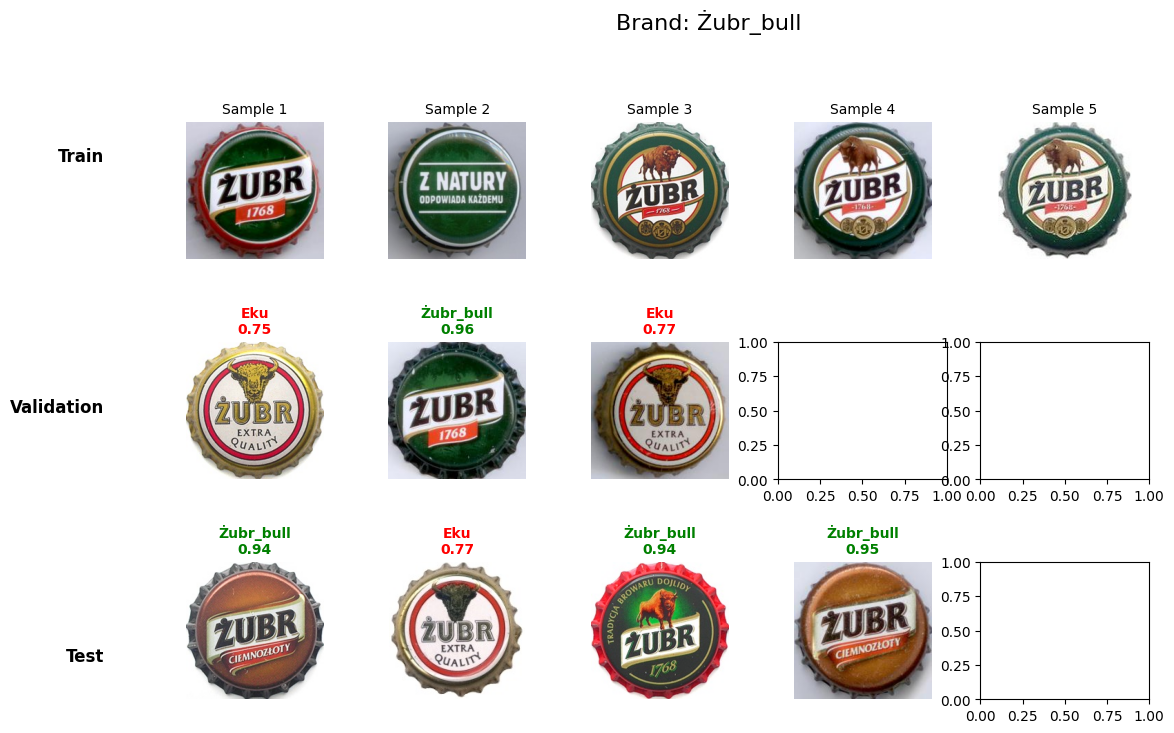

In [38]:
plot_sample_images_with_predictions(
    dataset_root='Dataset3.2',
    brand_groups=groups,
    eval_train_embedding=eval_train_embedding,
    eval_train_labels=eval_train_labels,
    label_to_brand=seen_idx_to_class,
    group_name='Mid', num_samples=5, transform=eval_transform,
    model=model,  # 👈 Make sure your model is passed here
    device=device)

### t-SNE 2d

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


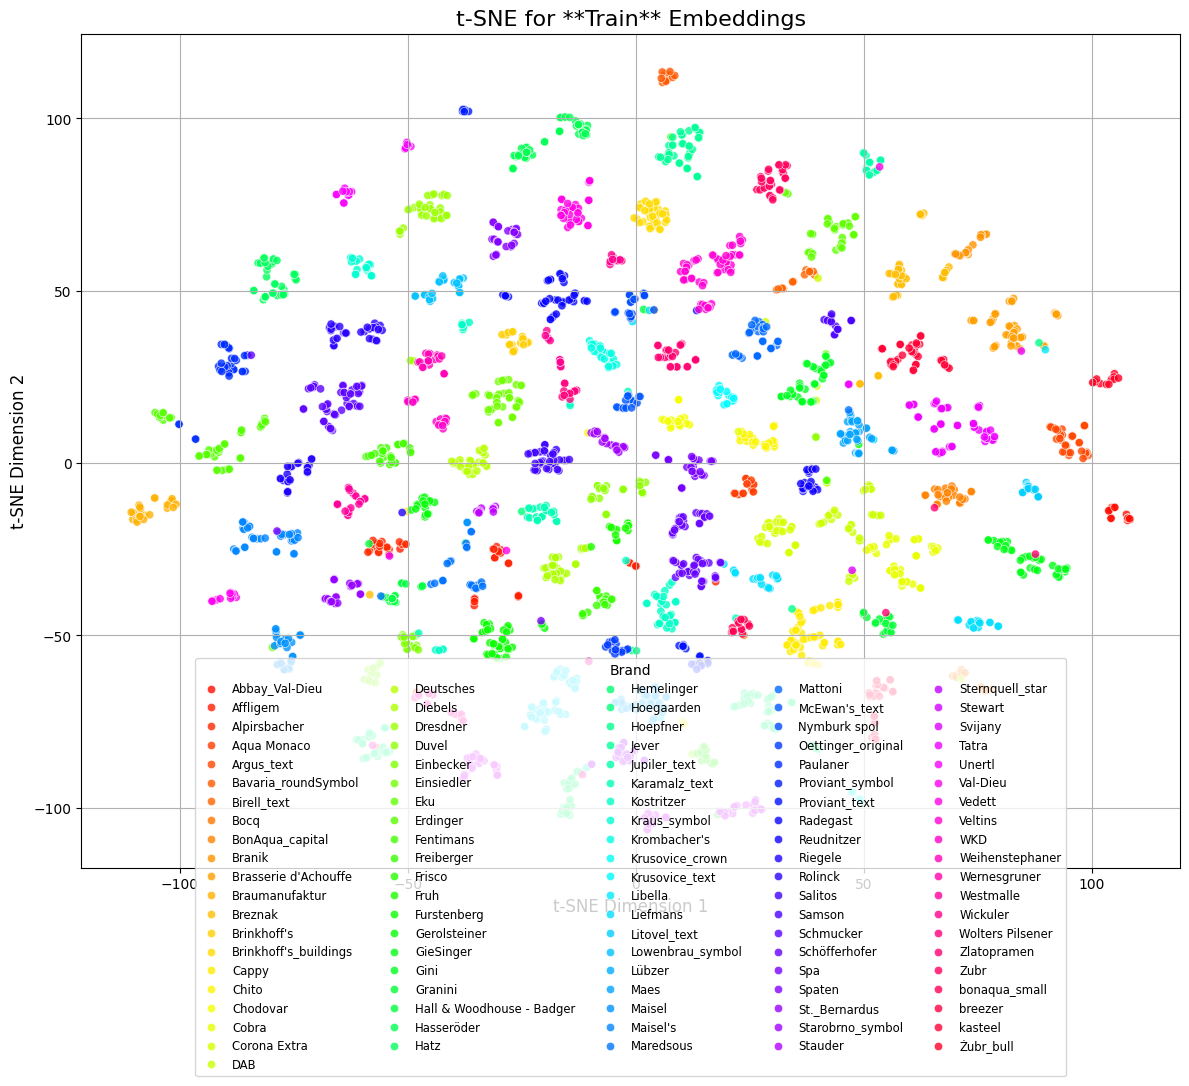

In [39]:
plot_tsne_embeddings(eval_train_embedding, eval_train_labels, seen_idx_to_class, title="t-SNE for **Train** Embeddings")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


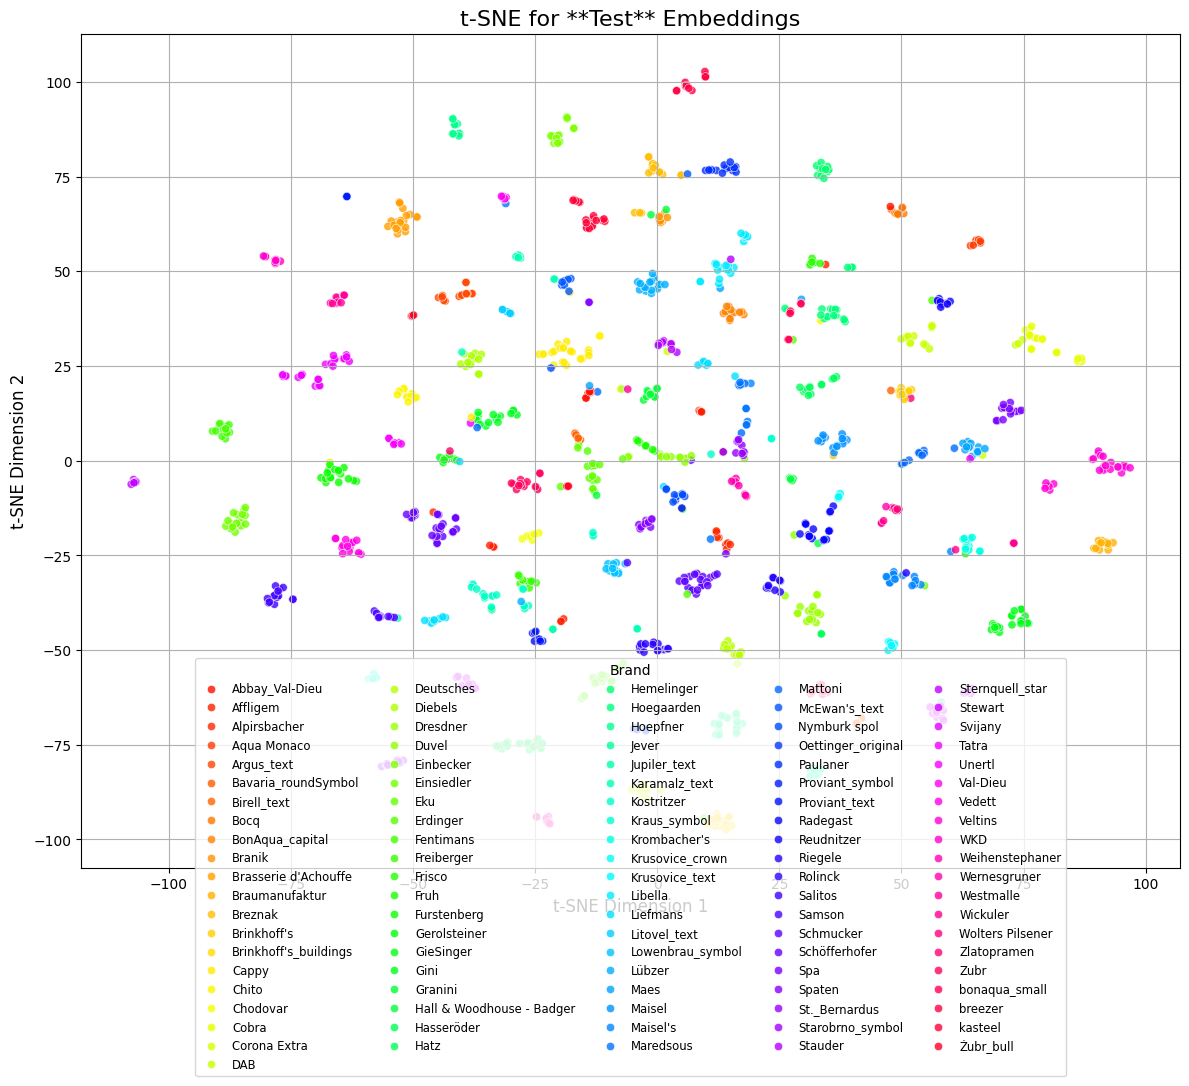

In [40]:
plot_tsne_embeddings(eval_test_embedding, eval_test_labels, seen_idx_to_class, title="t-SNE for **Test** Embeddings")

# Evaluation - Novel Brands

### Novel data preparation

In [18]:
# --- Data Setting ---
import zipfile, os

zip_path = "/content/novel_brands_50.zip"
DS_DIR_novel = "novel_brands"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(DS_DIR_novel)

print("✅ Dataset extracted to:", DS_DIR_novel)

✅ Dataset extracted to: novel_brands


In [19]:
DATA_NOVEL = f'{DS_DIR_novel}/novel_brands_50'
novel_dataset = BeerCapDataset(DATA_NOVEL, eval_transform)
novel_loader = DataLoader(novel_dataset, batch_size=batch_size, num_workers=2)
print(len(novel_dataset))


3346


### util function

In [20]:
from collections import defaultdict

def evaluate_overall_retrieval_performance(
    model: torch.nn.Module,

    train_loader: torch.utils.data.DataLoader,
    # val_loader: torch.utils.data.DataLoader,
    test_seen_loader: torch.utils.data.DataLoader,

    test_novel_loader: torch.utils.data.DataLoader,
    device: torch.device,
    k_shot_novel: int,
    k_values_for_recall: list = [1, 3, 5, 7],
    seen_class_to_idx=None,
    novel_class_to_idx=None
):


    # 1. Collect seen embeddings
    print("  Collecting embeddings for seen brands (train, val, test_seen)...")

    seen_train_embs, seen_train_labels = collect_embeddings(train_loader, model, device)
    # seen_val_embs, seen_val_labels = collect_embeddings_manual(val_loader, model, device)
    seen_test_embs, seen_test_labels = collect_embeddings(test_seen_loader, model, device)

    # 2. Collect novel embeddings
    print("  Collecting embeddings for novel brands...")
    all_novel_embs, all_novel_labels = collect_embeddings(test_novel_loader, model, device)

    # 3. Build global class mapping
    if seen_class_to_idx is None or novel_class_to_idx is None:
        raise ValueError("You must pass seen_class_to_idx and novel_class_to_idx to remap labels safely.")
    seen_idx_to_class = {v: k for k, v in seen_class_to_idx.items()}
    novel_idx_to_class = {v: k for k, v in novel_class_to_idx.items()}

    all_class_names = sorted(set(seen_class_to_idx.keys()).union(novel_class_to_idx.keys()))
    global_class_to_idx = {name: i for i, name in enumerate(all_class_names)}

    # 4. Remap seen labels
    remapped_seen_train_labels = torch.tensor([
        global_class_to_idx[seen_idx_to_class[l.item()]] for l in seen_train_labels
    ], dtype=torch.long)

    # remapped_seen_val_labels = torch.tensor([
    #     global_class_to_idx[seen_idx_to_class[l.item()]] for l in seen_val_labels
    # ], dtype=torch.long)

    remapped_seen_test_labels = torch.tensor([
        global_class_to_idx[seen_idx_to_class[l.item()]] for l in seen_test_labels
    ], dtype=torch.long)

    # 5. Split novel into support/query and remap
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(all_novel_labels):
        label_to_indices[label.item()].append(idx)

    novel_support_indices = []
    novel_query_indices = []
    num_skipped_classes = 0

    for label_id in sorted(label_to_indices.keys()):
        indices = label_to_indices[label_id]
        random.shuffle(indices)

        if len(indices) < k_shot_novel + 1:
            num_skipped_classes += 1
            continue

        novel_support_indices.extend(indices[:k_shot_novel])
        novel_query_indices.extend(indices[k_shot_novel:])

    if num_skipped_classes > 0:
        print(f"  Skipped {num_skipped_classes} novel classes due to insufficient samples (< {k_shot_novel + 1}).")

    novel_support_embs = all_novel_embs[novel_support_indices] if novel_support_indices else torch.empty(0, all_novel_embs.shape[1])
    novel_support_labels = all_novel_labels[novel_support_indices] if novel_support_indices else torch.empty(0, dtype=torch.long)

    novel_query_embs = all_novel_embs[novel_query_indices] if novel_query_indices else torch.empty(0, all_novel_embs.shape[1])
    novel_query_labels = all_novel_labels[novel_query_indices] if novel_query_indices else torch.empty(0, dtype=torch.long)

    remapped_novel_support_labels = torch.tensor([
        global_class_to_idx[novel_idx_to_class[l.item()]] for l in novel_support_labels
    ], dtype=torch.long)

    remapped_novel_query_labels = torch.tensor([
        global_class_to_idx[novel_idx_to_class[l.item()]] for l in novel_query_labels
    ], dtype=torch.long)

    # 6. Merge gallery and query sets
    gallery_embeddings = torch.cat([seen_train_embs, seen_test_embs, novel_support_embs], dim=0)
    gallery_labels = torch.cat([remapped_seen_train_labels, remapped_seen_test_labels, remapped_novel_support_labels], dim=0)

    query_embeddings = torch.cat([seen_test_embs, novel_query_embs], dim=0)
    query_labels = torch.cat([remapped_seen_test_labels, remapped_novel_query_labels], dim=0)

    print(f"  Total gallery samples: {len(gallery_embeddings)}")
    print(f"  Total query samples: {len(query_embeddings)}")
    print(f"  Unique gallery classes: {len(torch.unique(gallery_labels))}")
    print(f"  Unique query classes: {len(torch.unique(query_labels))}")

    # 7. Compute Recall@K
    # compute_cross_dataset_recall(eval_test_embedding, eval_test_labels, eval_train_embedding, eval_train_labels)
    overall_recalls = compute_cross_dataset_recall(
        query_embeddings, query_labels,
        gallery_embeddings, gallery_labels,

    )

    # print("--- Overall Retrieval Performance Evaluation Complete ---")
    return overall_recalls

### Evaluation Novels

In [53]:

overall_recalls = evaluate_overall_retrieval_performance(
                      model,
                      eval_train_loader,
                      # val_loader,
                      eval_test_loader,

                      novel_loader,
                      device,
                      k_shot_novel=5,
                      seen_class_to_idx=train_dataset.class_to_idx,
                      novel_class_to_idx=novel_dataset.class_to_idx
                  )

for key, value in overall_recalls.items():
    print(f"{key}: {value}")

  Skipped 1 novel classes due to insufficient samples (< 6).
  Total gallery samples: 4671
  Total query samples: 4466
  Unique gallery classes: 150
  Unique query classes: 150
Recall@1: 0.7134
Recall@3: 0.7557
Recall@5: 0.7718
